In [23]:
!pip3 install scikit-learn tqdm catboost optuna xgboost ipywidgets imblearn

In [56]:
import pandas as pd
import sklearn
import numpy as np
import random
import os
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold


In [57]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed=42
seed_everything(seed) # Seed 고정

In [58]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [59]:
def category_all(df_train, df_test):
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    'customer_idx',
    'lead_owner',
    ]
    for i in label_columns:
        df_train[i] = df_train[i].astype('category')
        df_test[i] = df_test[i].astype('category')
    return df_train, df_test    


def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""
    
    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

        
def manage_label_encoding(df_train, df_test):
    tmp = len(df_train)
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    
    df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

    for col in label_columns:
        df_all[col] = label_encoding(df_all[col])
    
    for col in label_columns:  
        df_train[col] = df_all.iloc[: tmp][col]
        df_test[col] = df_all.iloc[tmp :][col]

    return df_train, df_test

def preprocessing(df_train, df_test):
    df_train.drop_duplicates(keep='first', inplace=True)
    df_train.reset_index(inplace=True)
    df_train.drop('index',inplace=True, axis=1)
    df_test_id_temp = df_test['id'].copy()
    df_all = pd.concat([df_train,df_test.drop('id',axis=1)])
    df_all.drop('customer_country.1',axis=1,inplace=True)
    df_all.id_strategic_ver.fillna(0., inplace=True)
    df_all.it_strategic_ver.fillna(0., inplace=True)
    df_all.idit_strategic_ver.fillna(0., inplace=True)
    df_all.business_subarea.fillna('NAN', inplace=True)
    df_all.com_reg_ver_win_rate.fillna(0,inplace=True)
    df_all['customer_type'] = df_all['customer_type'].replace({
        'End-Customer':'End Customer'
    })
    df_all.customer_type.fillna('NAN',inplace=True)
    df_all.historical_existing_cnt.fillna(0, inplace=True)
    
    df_all.product_subcategory.fillna('NAN', inplace=True)
    
    df_all.product_modelname.fillna('NAN', inplace=True)

    df_all['expected_timeline'] = df_all['expected_timeline'].replace({
        'less_than_3_months': 'less than 3 months',
        'being followed up': 'being followed up.',
        'less than 6 months': '3 months ~ 6 months',
        '3_months_~_6_months' : '3 months ~ 6 months'
    })

    df_all.expected_timeline.fillna('NAN',inplace=True)
    df_all.ver_win_rate_x.fillna(0,inplace=True)
    df_all.ver_win_ratio_per_bu.fillna(0,inplace=True)
    df_all.business_area.fillna('NAN',inplace=True)
    df_all.customer_job.fillna('NAN', inplace=True)
    df_all.product_category.fillna('NAN', inplace=True)
    
    #처리못한부분
    #customer_country
    df_all.customer_country.fillna('NAN', inplace=True)
    #inquiry_type
    df_all.inquiry_type.fillna('NAN', inplace=True)

    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    ]
    
    #seperate
    tmp_len = len(df_train)
    df_train = df_all.iloc[: tmp_len ]
    df_test = df_all.iloc[tmp_len :]
    df_test = pd.concat([df_test,df_test_id_temp],axis=1)
    
    #RobustScaler
    robustScaler = RobustScaler()
    df_train['ver_win_rate_x'] = robustScaler.fit_transform(df_train[['ver_win_rate_x']])
    df_test['ver_win_rate_x'] = robustScaler.transform(df_test[['ver_win_rate_x']])
    robustScaler = RobustScaler()
    df_train['ver_win_ratio_per_bu'] = robustScaler.fit_transform(df_train[['ver_win_ratio_per_bu']])
    df_test['ver_win_ratio_per_bu'] = robustScaler.transform(df_test[['ver_win_ratio_per_bu']])
    ##############################
    
    return df_train, df_test


df_train, df_test = preprocessing(df_train, df_test)
df_train, df_test = category_all(df_train, df_test)
rate = ((len(df_train)-sum(df_train['is_converted']))/sum(df_train['is_converted']))
x_train, y_train = df_train.drop("is_converted",axis=1), df_train["is_converted"]

In [60]:
categorical_features = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    ]


train_pool = Pool(data=x_train, label=y_train, cat_features=categorical_features)

In [61]:
best_model = CatBoostClassifier(random_state=seed,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                verbose=100,)
    
best_model.fit(train_pool)

Learning rate set to 0.057369
0:	learn: 0.8377313	total: 21.6ms	remaining: 21.6s
100:	learn: 0.9437296	total: 4.06s	remaining: 36.2s
200:	learn: 0.9506856	total: 7.88s	remaining: 31.3s
300:	learn: 0.9558836	total: 11.6s	remaining: 26.9s
400:	learn: 0.9600449	total: 15.4s	remaining: 23.1s
500:	learn: 0.9630993	total: 19.2s	remaining: 19.1s
600:	learn: 0.9657523	total: 22.9s	remaining: 15.2s
700:	learn: 0.9692299	total: 26.7s	remaining: 11.4s
800:	learn: 0.9712354	total: 30.6s	remaining: 7.59s
900:	learn: 0.9733554	total: 34.6s	remaining: 3.8s
999:	learn: 0.9747696	total: 38.5s	remaining: 0us


In [62]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [63]:
train_pred = best_model.predict_proba(df_train.drop("is_converted",axis=1))
y = list(df_train['is_converted'])
threshold = min([num[1] if y[i] else 1 for i, num in enumerate(train_pred)])
train_y_pred = [True if i[1]>=0.5 else False for i in train_pred]
get_clf_eval(y, train_y_pred)

오차행렬:
 [[ 4614     6]
 [  433 50727]]

정확도: 0.9921
정밀도: 0.9142
재현율: 0.9987
F1: 0.9546


In [64]:
threshold

0.10502793333603613

In [66]:
categorical_features = label_columns = [
                                            "customer_country",
                                            "business_subarea",
                                            "business_area",
                                            "business_unit",
                                            "customer_type",
                                            "enterprise",
                                            "customer_job",
                                            "inquiry_type",
                                            "product_category",
                                            "product_subcategory",
                                            "product_modelname",
                                            "customer_position",
                                            "response_corporate",
                                            "expected_timeline",
                                            'customer_idx',
                                            'lead_owner',
]
# 
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pool = Pool(data=x_test, cat_features=categorical_features)


In [68]:
# 예측 수행 (soft voting)
pred = best_model.predict_proba(test_pool)
pred = [True if i[1]>=threshold else False for i in pred]
#pred = np.argmax(pred, axis=1)
sum(pred)

2782

In [54]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [38]:
real = pd.read_csv(r'submission(0.7688760806916426).csv')
get_clf_eval(real['is_converted'], pred)

오차행렬:
 [[1580  155]
 [ 132 3404]]

정확도: 0.9456
정밀도: 0.9229
재현율: 0.9107
F1: 0.9167


In [39]:
real = pd.read_csv(r'submission( 0.775599128540305).csv')
get_clf_eval(real['is_converted'], pred)

오차행렬:
 [[1667  280]
 [  45 3279]]

정확도: 0.9383
정밀도: 0.9737
재현율: 0.8562
F1: 0.9112


In [40]:
custom_pred = [True if (real['is_converted'][i] or pred[i]) else False for i in range(len(real))]   
sum(custom_pred)

1992

In [41]:
df_test.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_position', 'response_corporate',
       'expected_timeline', 'ver_cus', 'ver_pro', 'ver_win_rate_x',
       'ver_win_ratio_per_bu', 'business_area', 'business_subarea',
       'lead_owner', 'is_converted', 'id'],
      dtype='object')

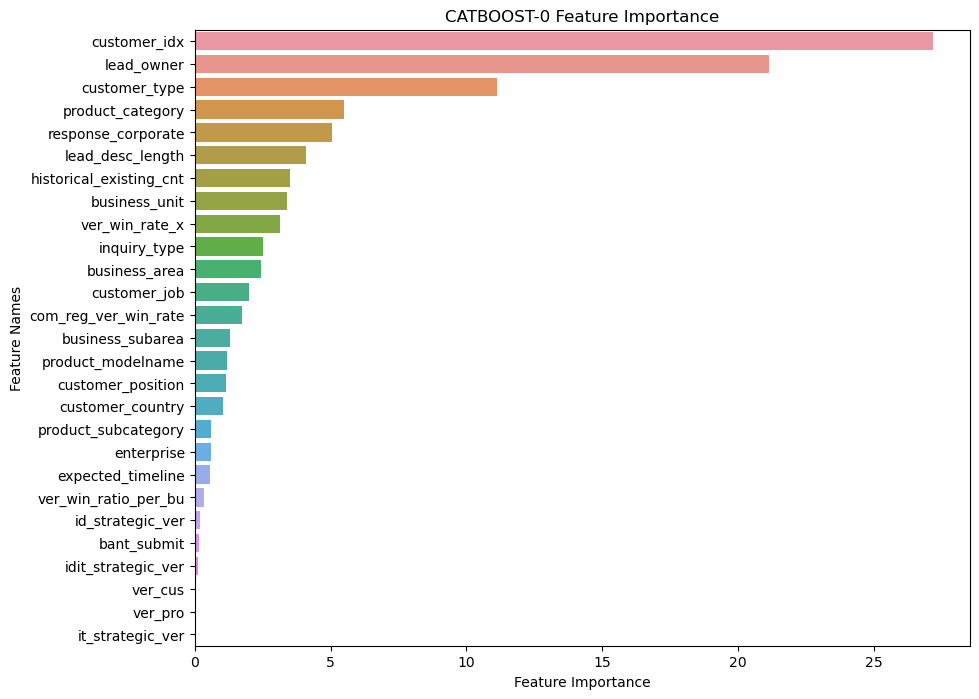

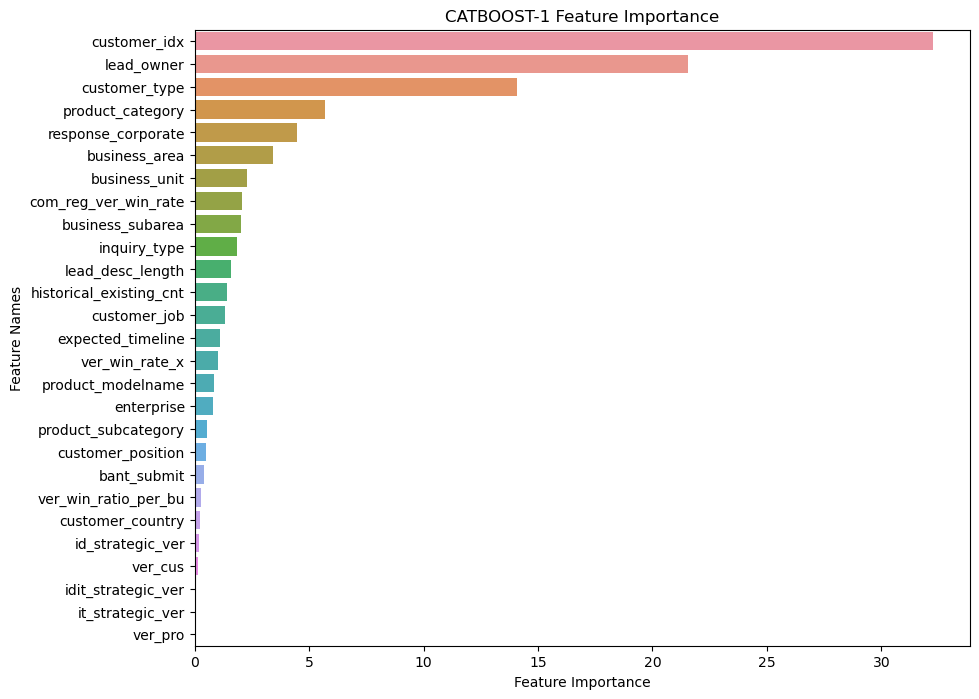

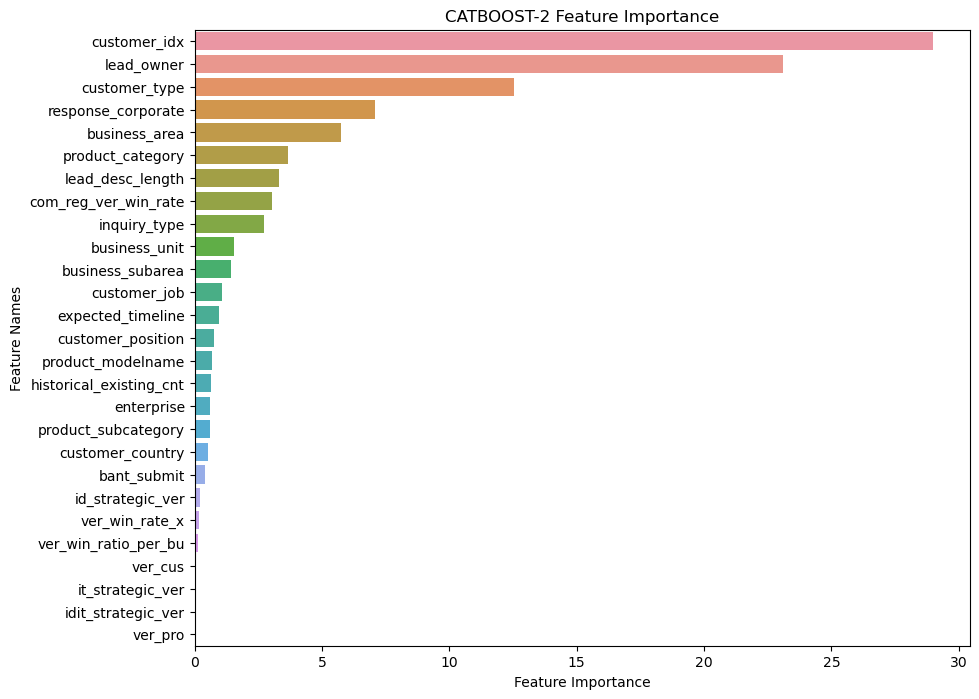

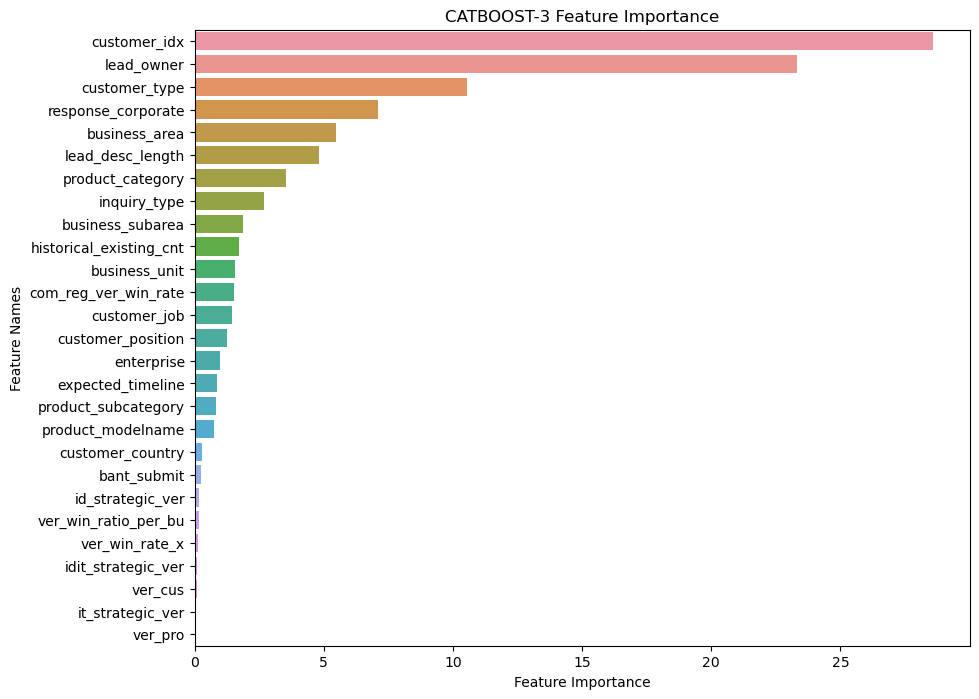

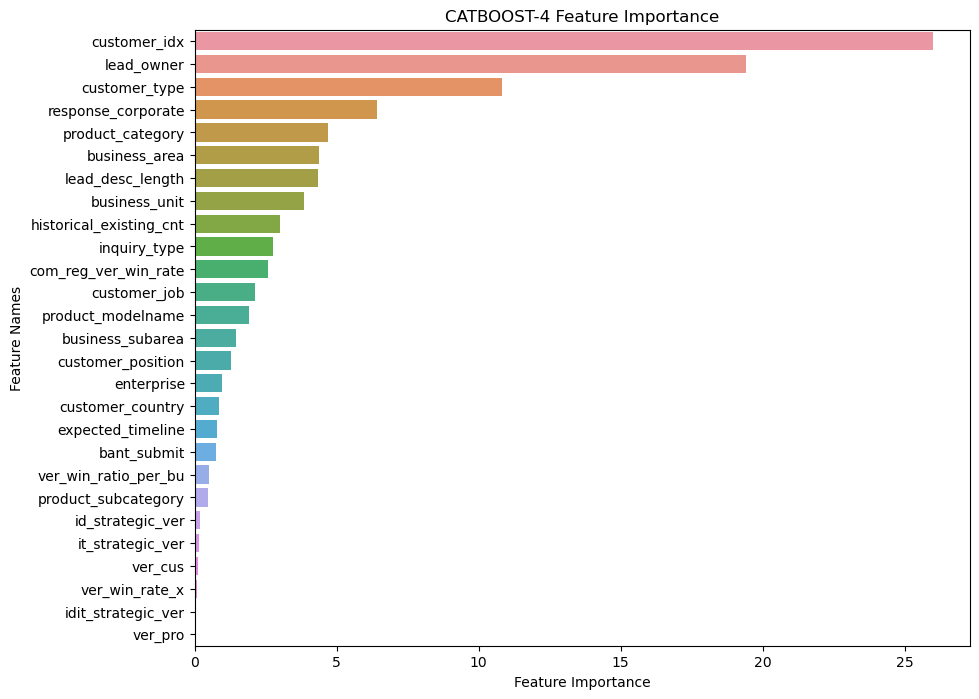

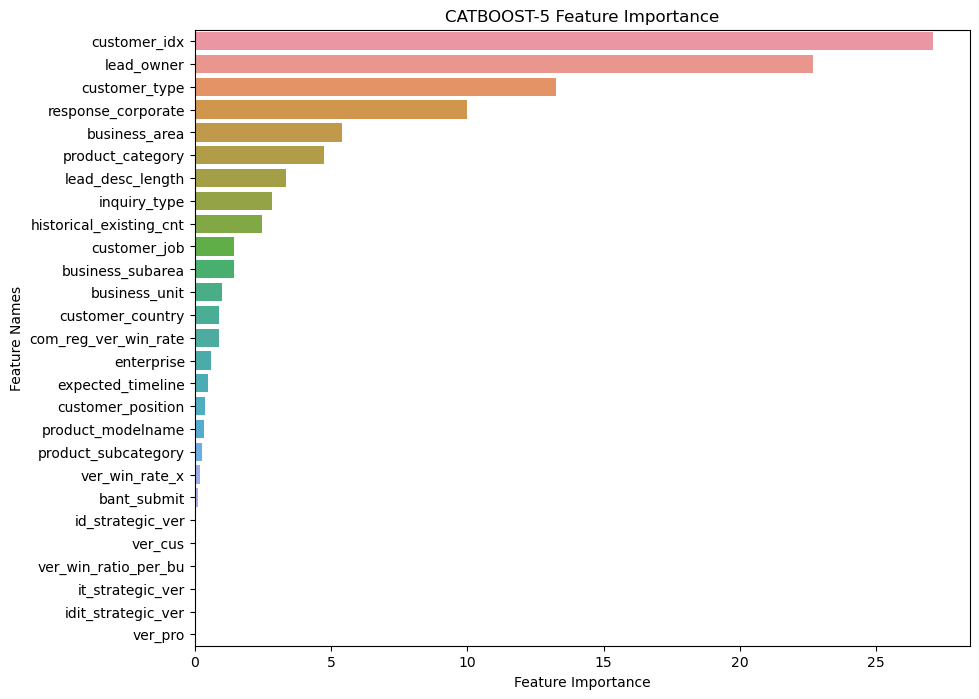

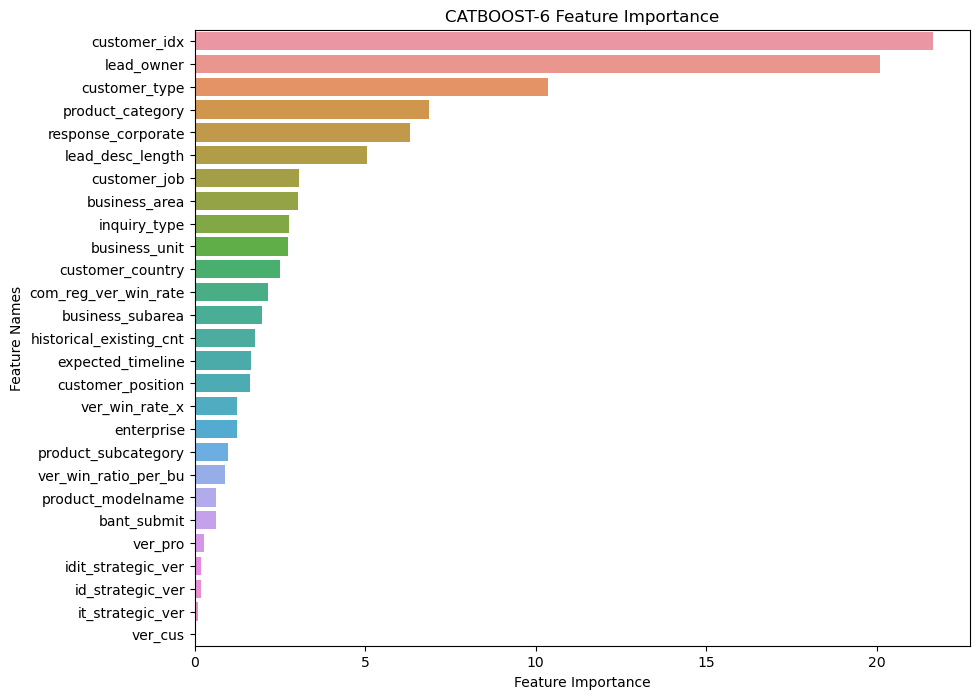

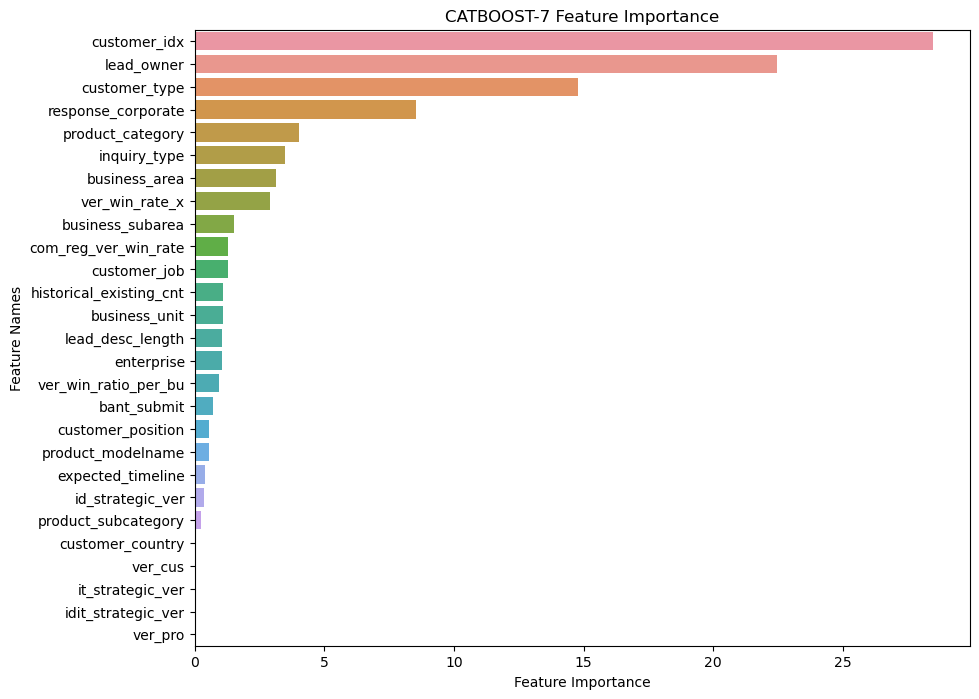

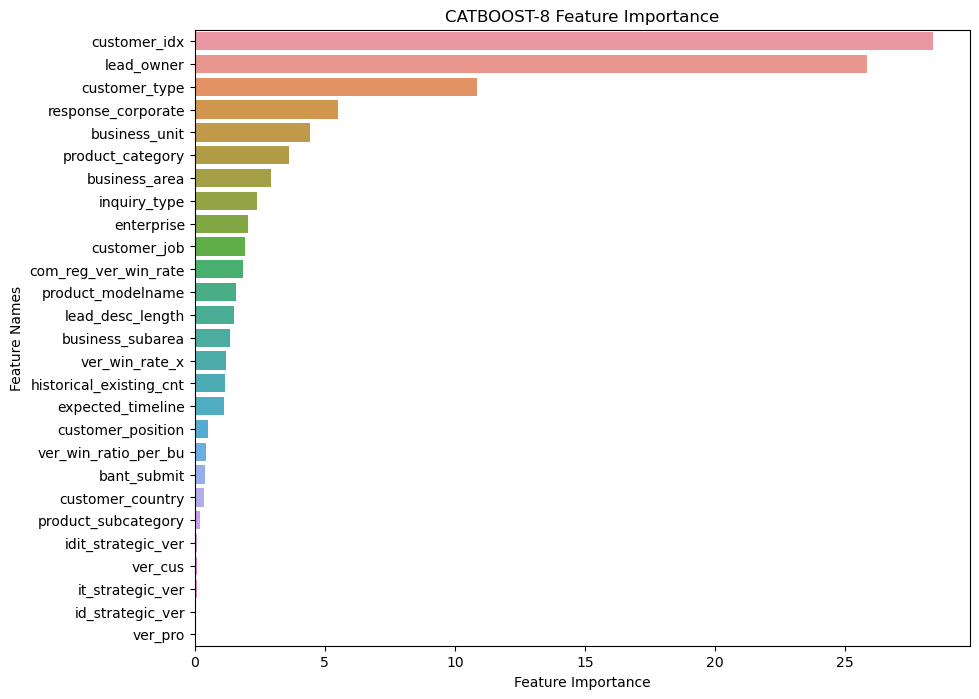

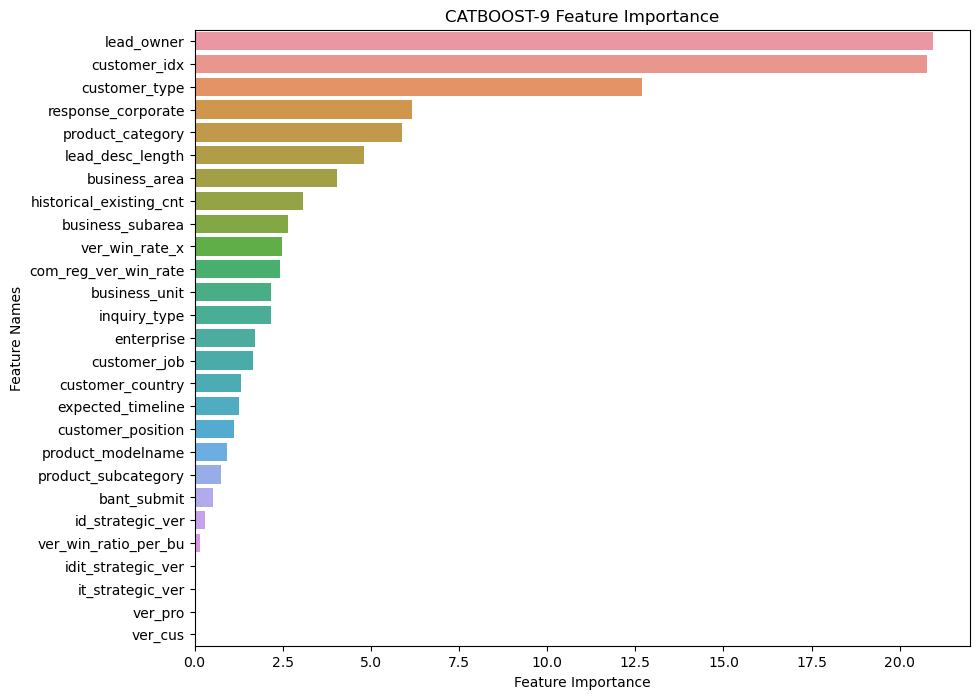

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
for i in range(10):
    plot_feature_importance(best_models[i].get_feature_importance(),df_test.drop(['is_converted','id'],axis=1).columns,f'CATBOOST-{i}')

In [20]:
train_pred = np.mean([best_model.predict_proba(df_train.drop("is_converted",axis=1)) for best_model in best_models], axis=0)
y = list(df_train['is_converted'])
threshold = min([num[1] if y[i] else 1 for i, num in enumerate(train_pred)])
train_y_pred = [True if i[1]>=0.5 else False for i in train_pred]
get_clf_eval(y, train_y_pred)

오차행렬:
 [[ 4606    14]
 [  930 50230]]

정확도: 0.9831
정밀도: 0.8320
재현율: 0.9970
F1: 0.9071


In [21]:
# all_train_pool = []
# all_val_pool = []
# all_y_val = []
for i in range(20):
    train_pred = np.mean([best_model.predict_proba(all_val_pool[i]) for best_model in best_models], axis=0)
    train_pred = np.argmax(train_pred, axis=1)
    get_clf_eval(all_y_val[i], train_pred)

오차행렬:
 [[ 462    0]
 [ 114 5002]]

정확도: 0.9796
정밀도: 0.8021
재현율: 1.0000
F1: 0.8902
오차행렬:
 [[ 461    1]
 [  94 5022]]

정확도: 0.9830
정밀도: 0.8306
재현율: 0.9978
F1: 0.9066
오차행렬:
 [[ 461    1]
 [  96 5020]]

정확도: 0.9826
정밀도: 0.8276
재현율: 0.9978
F1: 0.9048
오차행렬:
 [[ 460    2]
 [  90 5026]]

정확도: 0.9835
정밀도: 0.8364
재현율: 0.9957
F1: 0.9091
오차행렬:
 [[ 461    1]
 [  99 5017]]

정확도: 0.9821
정밀도: 0.8232
재현율: 0.9978
F1: 0.9022
오차행렬:
 [[ 459    3]
 [  70 5046]]

정확도: 0.9869
정밀도: 0.8677
재현율: 0.9935
F1: 0.9263
오차행렬:
 [[ 460    2]
 [ 112 5004]]

정확도: 0.9796
정밀도: 0.8042
재현율: 0.9957
F1: 0.8897
오차행렬:
 [[ 462    0]
 [  84 5032]]

정확도: 0.9849
정밀도: 0.8462
재현율: 1.0000
F1: 0.9167
오차행렬:
 [[ 458    4]
 [  95 5021]]

정확도: 0.9823
정밀도: 0.8282
재현율: 0.9913
F1: 0.9025
오차행렬:
 [[ 462    0]
 [  76 5040]]

정확도: 0.9864
정밀도: 0.8587
재현율: 1.0000
F1: 0.9240


IndexError: list index out of range

In [22]:
 # all_train_pool = []
# all_val_pool = []
# all_y_val = []
train_pred = [best_model.predict_proba(all_val_pool[i]) for i,best_model in enumerate(best_models)]
for i in range(10):
    print(i)
    train_pred[i] = np.argmax(train_pred[i], axis=1)
    get_clf_eval(all_y_val[i], train_pred[i])

0
오차행렬:
 [[ 443   19]
 [ 259 4857]]

정확도: 0.9502
정밀도: 0.6311
재현율: 0.9589
F1: 0.7612
1
오차행렬:
 [[ 442   20]
 [ 249 4867]]

정확도: 0.9518
정밀도: 0.6397
재현율: 0.9567
F1: 0.7667
2
오차행렬:
 [[ 442   20]
 [ 261 4855]]

정확도: 0.9496
정밀도: 0.6287
재현율: 0.9567
F1: 0.7588
3
오차행렬:
 [[ 435   27]
 [ 267 4849]]

정확도: 0.9473
정밀도: 0.6197
재현율: 0.9416
F1: 0.7474
4
오차행렬:
 [[ 433   29]
 [ 247 4869]]

정확도: 0.9505
정밀도: 0.6368
재현율: 0.9372
F1: 0.7583
5
오차행렬:
 [[ 444   18]
 [ 250 4866]]

정확도: 0.9520
정밀도: 0.6398
재현율: 0.9610
F1: 0.7682
6
오차행렬:
 [[ 444   18]
 [ 217 4899]]

정확도: 0.9579
정밀도: 0.6717
재현율: 0.9610
F1: 0.7907
7
오차행렬:
 [[ 441   21]
 [ 293 4823]]

정확도: 0.9437
정밀도: 0.6008
재현율: 0.9545
F1: 0.7375
8
오차행렬:
 [[ 439   23]
 [ 263 4853]]

정확도: 0.9487
정밀도: 0.6254
재현율: 0.9502
F1: 0.7543
9
오차행렬:
 [[ 442   20]
 [ 226 4890]]

정확도: 0.9559
정밀도: 0.6617
재현율: 0.9567
F1: 0.7823
